In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 불러오기
df = pd.read_csv('NVspinData_None_-1_230807.csv')

theta = df['Theta'].values
phi = df['Phi'].values
sequence = [eval(seq) for seq in df['combination'].values]
# sequence = df['combination'].apply(eval).tolist()

# sequence의 길이가 다를 수 있으므로 pad_sequences를 사용하여 동일한 길이로 맞춰줍니다.
max_seq_length = max([len(seq) for seq in sequence])
sequence_padded = pad_sequences(sequence, maxlen=max_seq_length, padding='post')

theta_train, theta_test, phi_train, phi_test, sequence_train, sequence_test = train_test_split(theta, phi, sequence_padded, test_size=0.2)
theta_train, theta_val, phi_train, phi_val, sequence_train, sequence_val = train_test_split(theta_train, phi_train, sequence_train, test_size=0.2)


In [ ]:

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 SimpleRNN 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이
rnn_layer = SimpleRNN(64, return_sequences=True, name='rnn_layer')(repeated_vector)
output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_test, phi_test], np.expand_dims(sequence_test, -1)), epochs=50, batch_size=64)

# 검증
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


In [26]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 134ms/step
Sample 1:
Theta    : 2.93030085
Phi      : 2.140988622
Actual   : [3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 4 1 1 0 0]
Predicted: [3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 4 1 1 0 0]
----------
Sample 2:
Theta    : 0.376414335
Phi      : 4.412148611
Actual   : [3 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted: [2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------
Sample 3:
Theta    : 0.561145689
Phi      : 6.196009895
Actual   : [2 4 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted: [4 4 1 1 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------
Sample 4:
Theta    : 2.23052002
Phi      : 5.27009011
Actual   : [4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 4 2 0 0 0 0 0 0 0 0 0 0]
Predicted: [2 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 0 0 0 0 0 0 0 0 0 0]
----------
Sample 5:
Theta   

In [30]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples,
    'Phi': phi_samples,
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 CSV 파일로 저장
df_results.to_csv('rnn_results2.csv', index=False)

print("Results saved to rnn_results.csv")


1/1 [==============================] - 0s 21ms/step
Results saved to rnn_results.csv


In [16]:
print(type(theta_train), theta_train.shape)
print(type(phi_train), phi_train.shape)
print(type(sequence_train), len(sequence_train))
print(type(theta_val), theta_val.shape)
print(type(phi_val), phi_val.shape)
print(type(sequence_val), len(sequence_val))

<class 'numpy.ndarray'> (7904,)
<class 'numpy.ndarray'> (7904,)
<class 'numpy.ndarray'> 7904
<class 'numpy.ndarray'> (1976,)
<class 'numpy.ndarray'> (1976,)
<class 'numpy.ndarray'> 1976


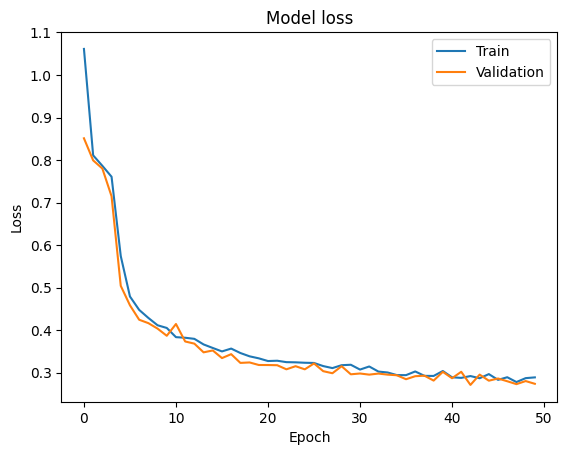

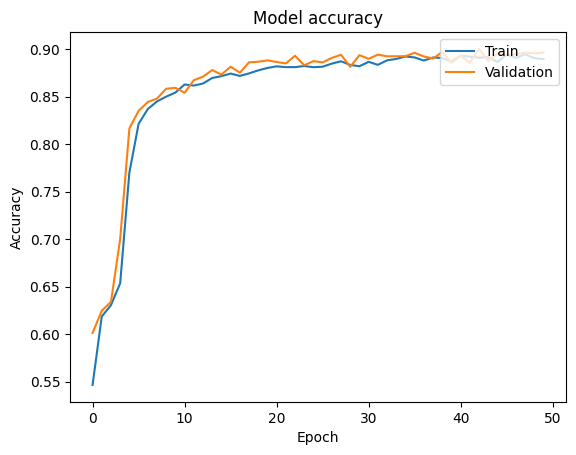

 1/78 [..............................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8875

c:\Python310\lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['sequence_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


78/78 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.8963
Test Accuracy: 89.63
Test Loss: 27.40


In [28]:
import matplotlib.pyplot as plt

def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)

In [40]:
# 새로운 theta와 phi 값 정의
new_theta = np.array([np.pi/2])  # 예시 값
new_phi = np.array([np.pi*0])    # 예시 값

# 모델로 예측
predicted_sequence = model.predict([new_theta, new_phi])

# 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)
print(predicted_sequence_indices[0])

1/1 [==============================] - 0s 27ms/step
[1 1 1 1 3 3 2 4 4 1 1 3 3 2 2 4 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
# 새로운 theta와 phi 값 정의
new_theta = np.array([0.721898974])  # 예시 값
new_phi = np.array([5.172173873])    # 예시 값

# 모델로 예측
predicted_sequence = model.predict([new_theta, new_phi])

# 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)
print(predicted_sequence_indices[0])

1/1 [==============================] - 0s 22ms/step
[4 4 4 1 1 3 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# 새로운 theta와 phi 값 정의
new_theta = np.array([2.617163252])  # 예시 값
new_phi = np.array([3.74399407])    # 예시 값

# 모델로 예측
predicted_sequence = model.predict([new_theta, new_phi])

# 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)
print(predicted_sequence_indices[0])

1/1 [==============================] - 0s 20ms/step
[3 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 0 0 0 0 0 0 0 0 0]


In [9]:
# 새로운 theta와 phi 값 정의
new_theta = np.array([3.111441191])  # 예시 값
new_phi = np.array([1.647178737])    # 예시 값

# 모델로 예측
predicted_sequence = model.predict([new_theta, new_phi])

# 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)
print(predicted_sequence_indices[0])

1/1 [==============================] - 0s 18ms/step
[1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 2 4 4 1 0 0]
